Date: 19.05.2023 \
Author: Reto Hendry

This scripts is used to find out the feature importance of the best performing models on the parameter set which is best for all models.

The best parameters are resample cube 3 and number of features 70. This can be seen in the script "etric_analysis_autoML_tools.ipynb"

In [92]:
import numpy as np
import pandas as pd
import h2o
import os
import sys
import datetime
from matplotlib import pyplot as plt

from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.base import BaseEstimator

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from functions.function_get_label_df import get_label_df
from functions.function_get_component_array import get_component_array
from functions.function_get_best_features import get_best_features_sorted
from functions.function_resample_4d_array import resample_4d_array

## Prepare data

In [93]:
# parameters to define
component = [1]
resample_cube = 3
number_of_features = 70

##############################################

# get the label data
df_label = get_label_df(data_path_optional="../../data/")

# get the MVPA data arrays
component_array_5d = get_component_array(component, data_path_optional="../../data/")
print(f"shape of component_array_5d: {component_array_5d.shape}")

sample_array_4d = resample_4d_array(component_array_5d[0], resample_cube)
print(f"shape of resampled sample_array_4d: {sample_array_4d.shape}")

# get the sorted feature list
best_feature_list = get_best_features_sorted(
    sample_array_4d, df_label
)

# select desired number of features
best_features = best_feature_list[:number_of_features]

/home/tahendry/Documents/master_thesis/master_thesis_repo/functions/function_get_label_df.py:42: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  df_label = (pd.read_excel(os.path.join(data_path, label_file),


shape of component_array_5d: (1, 90, 91, 109, 91)
Resampling in progress...


100%|██████████| 90/90 [00:00<00:00, 95.21it/s] 


shape of resampled sample_array_4d: (90, 31, 37, 31)
Calculating list of best features ...


100%|██████████| 35556/35556 [00:33<00:00, 1069.46it/s]


In [94]:
# reshape 4d array to dataframe
sample_df = pd.DataFrame(
    sample_array_4d.reshape(sample_array_4d.shape[0], -1)
    ).iloc[:, best_features]

# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(
    sample_df, 
    df_label["Cond"], 
    test_size=0.2, 
    random_state=42,
    stratify=df_label["Cond"]
)

# Convert the column names of x_train and x_test to strings
    # the conversion into strings is necessary for the H2O AutoML
    # the h2o dataframes convert all types to strings
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

# initialize h2o server
h2o.init(
    ip="localhost", 
    port=54323,
    nthreads=-1,
    min_mem_size=64,  # 64 GB
    max_mem_size=160,  # 160 GB
)

# Convert train and test sets to H2O DataFrames 
x_train_h2o = h2o.H2OFrame(pd.concat([x_train, y_train], axis=1))
x_test_h2o = h2o.H2OFrame(pd.concat([x_test, y_test], axis=1))

x_features = x_train.columns.tolist()
y_label = "Cond"

x_train_h2o[y_label] = x_train_h2o[y_label].asfactor()
x_test_h2o[y_label] = x_test_h2o[y_label].asfactor()

Checking whether there is an H2O instance running at http://localhost:54323. connected.


H2O_cluster_uptime:,2 hours 46 mins
H2O_cluster_timezone:,Europe/Zurich
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,3 months and 11 days
H2O_cluster_name:,H2O_from_python_tahendry_a3aarn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,159.9 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Load and deploy model

In [95]:
# load the best model
model_path = "../param_sweep_best_models/h2o_best_models/h2o_model_20230519_165118/GLM_1_AutoML_1_20230519_164158"

In [96]:
# Load the saved model
loaded_model = h2o.load_model(model_path)
print(loaded_model)

# Perform prediction on the same training data
predictions = loaded_model.predict(x_test_h2o)

# Convert the predictions to a pandas dataframe
predictions_df = predictions.as_data_frame()

Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20230519_164158


GLM Model: summary
    family    link    regularization              lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    binomial  logit   Ridge ( lambda = 0.06816 )  nlambda = 30, lambda.max = 20.714, lambda.min = 0.06816, lambda.1se = 0.2428  70                            70                             38                      AutoML_1_20230519_164158_training_py_10_sid_966a

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.04038665642721206
RMSE: 0.2009643163031986


In [97]:
np.array(predictions_df.loc[:, "predict"])

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [98]:
np.array(y_test)

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [99]:
# cv-accuracy and cv-standard deviation from best model
cv_metrics = loaded_model.cross_validation_metrics_summary().as_data_frame()
cv_mean_accuracy = cv_metrics.loc[cv_metrics[""]=="accuracy", "mean"].values[0]
cv_std = cv_metrics.loc[cv_metrics[""]=="accuracy", "sd"].values[0]

### calculate test metrics
test_pred = loaded_model.predict(x_test_h2o).as_data_frame().loc[:,"predict"]
test_accuracy = accuracy_score(y_test, test_pred)
test_f1_score = f1_score(y_test, test_pred, average="weighted")
test_precision_score = precision_score(y_test, test_pred, average="weighted")


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [100]:
# print all the results
print(f"cv_mean_accuracy: {cv_mean_accuracy}")
print(f"cv_std: {cv_std}")
print(f"test_accuracy: {test_accuracy}")
print(f"test_f1_score: {test_f1_score}")
print(f"test_precision_score: {test_precision_score}")

cv_mean_accuracy: 0.9166667
cv_std: 0.088388346
test_accuracy: 0.9444444444444444
test_f1_score: 0.9442724458204333
test_precision_score: 0.9500000000000001


## get feature importance

In [101]:
# Get the variable importance
feature_importance = loaded_model.varimp()
# If you want to convert the feature importance to a pandas dataframe for better readability:
feature_importance_df = pd.DataFrame(feature_importance, 
                                     columns=['Feature', 'Relative_Importance', 'Scaled_Importance', 'Percentage'])

feature_importance_df = (feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=True)
                        .set_index('Feature'))

feature_importance_df

,Relative_Importance,Scaled_Importance,Percentage
Feature,,,
16748,0.001338,0.002234,0.000125
17987,0.004816,0.008037,0.000450
18756,0.004966,0.008288,0.000464
16560,0.005093,0.008501,0.000476
17738,0.008132,0.013573,0.000760
...,...,...,...
11105,0.334798,0.558790,0.031278
6424,0.338925,0.565678,0.031664
9689,0.410569,0.685253,0.038357


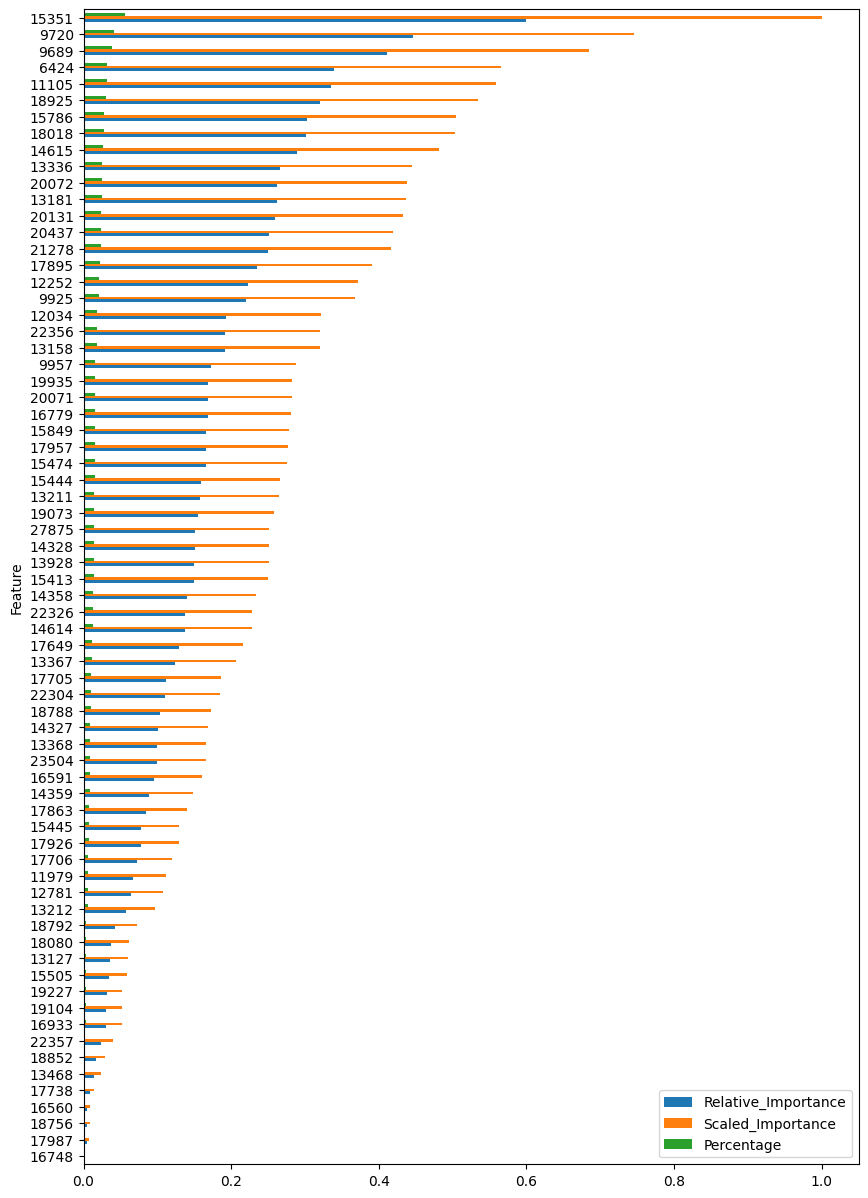

In [102]:
feature_importance_df.plot(kind='barh', figsize=(10, 15))
plt.show()

In [103]:
# export to a csv file
feature_importance_df.to_csv("feature_importance_h2o.csv")

In [104]:
# stop h2o server
# h2o.shutdown(prompt=False)